In [344]:
import numpy as np
from collections import deque
import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [352]:
class VoxelMap:
    def __init__(self):
        self.__voxelMapSize = np.zeros((3,), dtype=np.uint)     # Map's grid number Vector3 uint
        self.__voxelMapGridSize = np.zeros((3,), dtype=float)   # One grid size Vector3 float
        self.__voxelMapMinCorner = np.zeros((3,), dtype=float)  # Coordinates of min corner Vector3 float
        self.__voxelMapData = np.empty((0), dtype=bool)         # Obstacles = True, free = False

    def LoadVoxelMap(self, full_path: str) -> bool:
        try:
            f = open(full_path)
            # Get voxelMap size
            counter = 0
            for word in f.readline().split(maxsplit=3):
                if word.isdecimal():
                    self.__voxelMapSize[counter] = int(word)
                else:
                    print("Unexpected word: " + word)
                    return False
                counter += 1

            # Get voxelMap grid size
            counter = 0
            for word in f.readline().split(maxsplit=3):
                word = word.replace(",", ".", 1)
                self.__voxelMapGridSize[counter] = float(word)
                counter += 1

            # Get voxelMap min corner
            counter = 0
            for word in f.readline().split(maxsplit=3):
                word = word.replace(",", ".", 1)
                self.__voxelMapMinCorner[counter] = float(word)
                counter += 1

            # Get voxelMap data
            line = f.readline()
            self.__voxelMapData = np.zeros(self.__voxelMapSize, dtype=bool)
            while line:
                words = line.split(maxsplit=4)
                if not(words[0].isdecimal() and words[1].isdecimal() and words[2].isdecimal()):
                    print("Invalid data in words: " + words)
                    return False
                value = True if words[3] == "True" else "False"
                self.__voxelMapData[int(words[0]), int(words[1]), int(words[2])] = value
                line = f.readline()
            f.close()
            
            print("VoxelMap size:", self.__voxelMapData.shape)
            print("VoxelMap grid size:", self.__voxelMapGridSize)
            print("VoxelMap min corner:", self.__voxelMapMinCorner)
            return True
        except FileNotFoundError:
            print("No such file:" , full_path)
            return False

    def GetGridSize(self) -> np.ndarray:
        return self.__voxelMapGridSize

    def GetMinCorner(self) -> np.ndarray:
        return self.__voxelMapMinCorner

    def GetMapData(self) -> np.ndarray:
        return self.__voxelMapData

    def Plot3DMap(self):
        x, y, z = self.__voxelMapData.nonzero()
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.azim = 90
        ax.elev = 0
        ax.scatter(x, y, z, marker='x', c="red")
        return fig, ax

    def __IsOnMap(self, state: np.ndarray) -> bool:
        return (state >= np.zeros((3, ), dtype=np.uint)).all() and (state < self.__voxelMapSize).all()

    def IsObastacle(self, state: np.ndarray) -> bool:
        x, y, z = state
        return (not self.__IsOnMap(state)) or (self.__voxelMapData[x, y, z])
        

In [353]:
class GraphNode:
    def __init__(self):
        self.parent

class Graph:
    def __init__(self, root_node):
        self.__graph = {tuple(root_node) : [] }

    def Append(self, node: np.ndarray, parent: np.ndarray):
        self.__graph[tuple(parent)].append(tuple(node))
        self.__graph[tuple(node)] = []

In [354]:
class AlgorithmBase:
    def __init__(self):
        self.__startState = np.ndarray((3,), dtype=float)         # Store float [x, y, z]
        self.__goalState = np.ndarray((3,), dtype=float)          # Store float [x, y, z]

    def SetStartState(self, state :np.ndarray):
        assert self.__startState.shape == state.shape, \
            "setStartState(): " + str(self.__startState.shape) + " != " + str(state.shape)
        self.__startState = state
        print("New start state: ", self.__startState)
        
    def SetGoalState(self, state :np.ndarray):
        assert self.__goalState.shape == state.shape, \
            "setStartState(): " + str(self.__goalState.shape) + " != " + str(state.shape)
        self.__goalState = state
        print("New start state: ", self.__goalState)

    def GetStartState(self) -> np.ndarray:
        return self.__startState

    def GetGoalState(self) -> np.ndarray:
        return self.__goalState


In [415]:
class Descrete(AlgorithmBase):
    def __init__(self):
        super().__init__()
        self.__voxelMap = VoxelMap()
        self.startStateDescrete = np.ndarray((3,), dtype=np.uint)         # Store int [x, y, z]
        self.goalStateDescrete = np.ndarray((3,), dtype=np.uint)          # Store int [x, y, z]

        self.__queue = deque()

    def LoadVoxelMap(self, full_path: str = "map.txt") -> bool:
        self.__voxelMap.LoadVoxelMap(full_path = full_path)
    
    def ShowVoxelMap(self, is3D = True):
        return self.__voxelMap.Plot3DMap()

    def ShowState(self, axes, state: np.ndarray, color = "blue"):
        x, y, z = state
        axes.scatter(x, y, z, c=color, s=50)

    def GetGraph(self):
        return self.__graph
        
    def __getDescreteState(self, state: np.ndarray) -> np.ndarray:
        assert self.__voxelMap.GetGridSize().shape == state.shape, "__GetDescreteState(): Wrong shape!"
        state -= self.__voxelMap.GetMinCorner()
        return np.array(state/self.__voxelMap.GetGridSize() , dtype=np.uint)

    def __FindLowerBound(self, item, min, max):
        if (max - min == 1):
            key, _ = self.__queue[min]
            return min if item[0] < key else max
        mean = (max + min) // 2
        key, _ = self.__queue[mean]
        if key > item[0]:
            max = mean
        else:
            min = mean
        return self.__FindLowerBound(item, min, max)

    def __Insert(self,cost:int, state: np.ndarray):
        if (self.__queue.__len__() == 0):
            self.__queue.append((cost, state))
        else:
            min_id = 0
            max_id = self.__queue.__len__()
            id = self.__FindLowerBound((cost, state), min_id, max_id)
            self.__queue.insert(id, (cost, state))
        return

    def __SetVisited(self, cost: int, state: np.ndarray):
        x, y, z = state
        self.__visitedMap[x, y, z] = (True, cost)
            
    def __GetActionSpace(self):
        actionSpace = []
        for x in [1, 0, -1]:
            for y in [0]:
                for z in [1, 0, -1]:
                    if (x == 0) and (y == 0) and (z == 0):
                        continue
                    action = np.array([x, y, z], dtype=int)
                    actionSpace.append(action)
        return actionSpace

    def __GetActionCost(self, action: np.ndarray) -> int:
        return 1 if action[1] == 0 else 2

    def __GetHeuristic(self, state):
        delta = self.goalStateDescrete - state
        return np.linalg.norm(delta[:-1], ord=2)

    def __IsNearGoal(self, state) -> bool:
        return ((self.goalStateDescrete[0] == state[0]) and (self.goalStateDescrete[2] == state[2]))

    def GetGlobalPlan(self) -> bool:
        fig, axes = ppAlg.ShowVoxelMap()

        # Descretize start/goal states
        self.startStateDescrete = self.__getDescreteState(self.GetStartState())
        self.goalStateDescrete = self.__getDescreteState(self.GetGoalState())
        
        print("startStateDescrete", self.startStateDescrete)
        print("goalStateDescrete", self.goalStateDescrete)
        
        if self.__voxelMap.IsObastacle(self.startStateDescrete):
            print("Start state is obstacle or out of box")
            return False
        if self.__voxelMap.IsObastacle(self.goalStateDescrete):
            print("Goal state is obstacle or out of box")
            return False

        self.ShowState(axes, ppAlg.startStateDescrete, "blue")
        self.ShowState(axes, ppAlg.goalStateDescrete, "green")

        # Init Map for visitted states
        self.__visitedMap = np.zeros_like(self.__voxelMap.GetMapData(), dtype=tuple)
        self.__visitedMap.fill((False,0))

        # Init graph
        self.__graph = Graph(self.startStateDescrete)

        self.__Insert( 0, self.startStateDescrete )
        self.__SetVisited( 0, self.startStateDescrete )

        start = time.time()
        counter = 200
        while (len(self.__queue) > 0 and counter > 0):
            _ , currentState = self.__queue.popleft()

            # if (currentState == self.goalStateDescrete).all():
            if self.__IsNearGoal(currentState):
                print("Finished in", time.time() - start, "sec.")
                return True

            actionSpace = self.__GetActionSpace()
            for action in actionSpace:
                nextState = currentState + action

                if self.__voxelMap.IsObastacle(nextState):
                    # are we able to climb obstacle?
                    lifting = np.array([0, 1, 0], dtype=int)
                    if self.__voxelMap.IsObastacle(nextState + lifting):
                        self.ShowState(axes, nextState, color="red")
                        continue
                    else:
                        action += lifting
                        nextState += lifting

                descent = np.array([0, -1, 0], dtype=int)
                if not self.__voxelMap.IsObastacle(nextState + descent):
                    action += descent
                    nextState += descent

                x, y, z = nextState
                isVisited, currentCost = self.__visitedMap[x, y, z]
                if not isVisited:
                    self.ShowState(axes, nextState, color="gray")
                    nextCost = currentCost + self.__GetActionCost(action)
                    self.__SetVisited(nextCost, nextState)
                    self.__Insert(nextCost + self.__GetHeuristic(nextState), nextState)
                    
                    self.__graph.Append(nextState, currentState)
                    
                else:
                    newCost = currentCost + self.__GetActionCost(action)
                    if newCost < nextCost:
                        self.__SetVisited(nextState, newCost)
                        self.__graph.Append(nextState, currentState)

            counter -= 1
        
        print("No path exists. Last state:", currentState)
        self.ShowState(axes, currentState, color="black")
        return False


VoxelMap size: (32, 32, 32)
VoxelMap grid size: [0.28875    0.02822887 0.6259375 ]
VoxelMap min corner: [ -4.62        -0.03166193 -10.015     ]
New start state:  [0.  0.5 0. ]
New start state:  [0.  0.5 7. ]
startStateDescrete [16 18 16]
goalStateDescrete [16 18 27]
No path exists. Last state: [18 13 13]


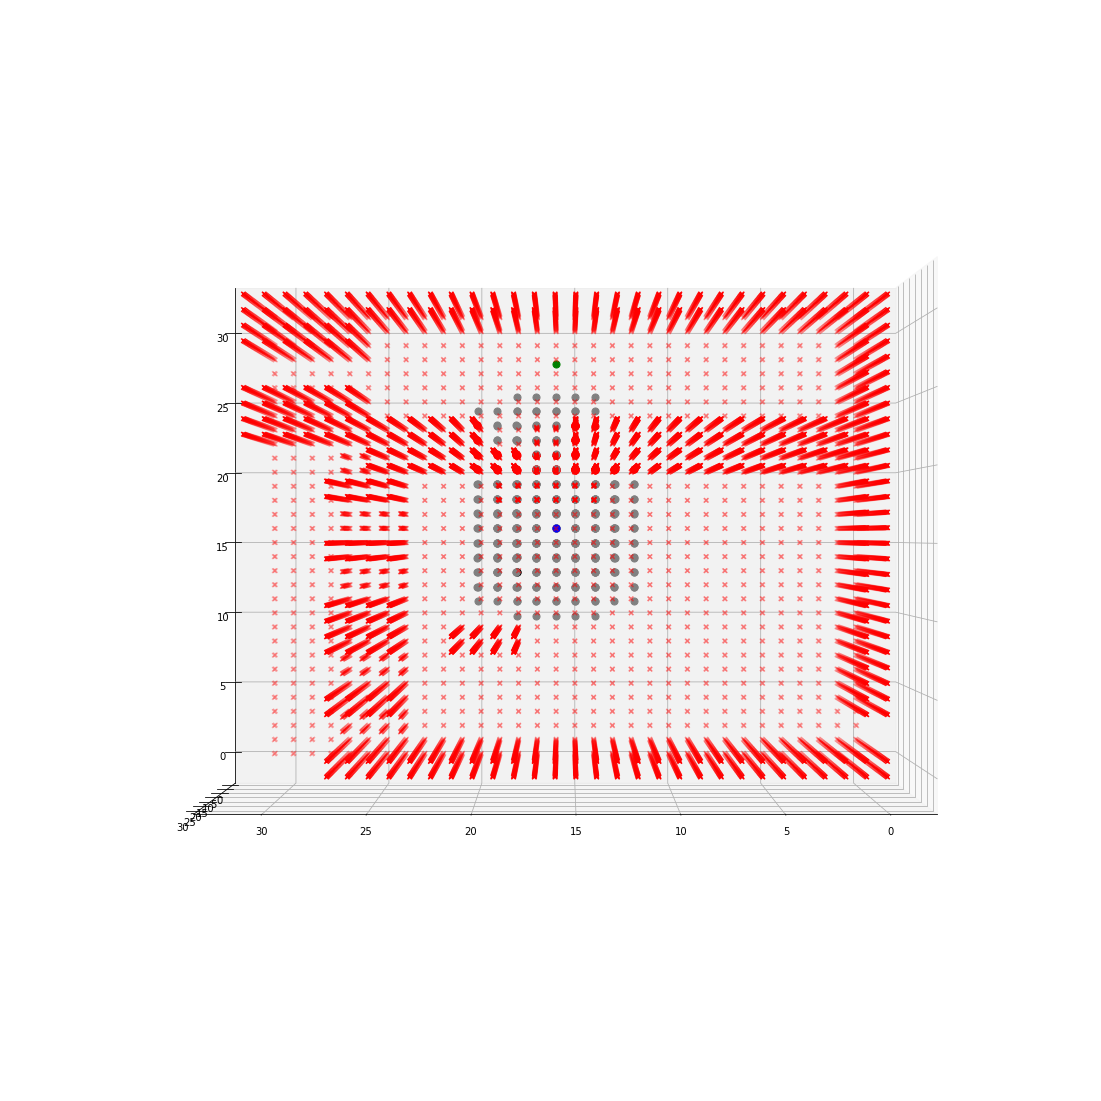

In [416]:
ppAlg = Descrete()
ppAlg.LoadVoxelMap(full_path = "D:/catkin_ws/src/VRPP_ROS/launch/map.txt")

goalState = np.array([0.0, 0.5, 7.0], dtype=float)
startState = np.array([0.0, 0.5, 0.0], dtype=float)
ppAlg.SetStartState(startState)
ppAlg.SetGoalState(goalState)

ppAlg.GetGlobalPlan()

graph = ppAlg.GetGraph()
# graph.PlotGraph()
    
plt.show()